Copyright 2019 Almintas Povilaitis

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.



## Prep work

### Download relevant libraries and check the setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tensorflow-gpu==2.0.0-alpha0
import tensorflow as tf

import numpy as np
import os
import datetime

     |████████████████████████████████| 332.1MB 34kB/s 
     |████████████████████████████████| 3.0MB 45.7MB/s 
     |████████████████████████████████| 419kB 48.5MB/s 
     |████████████████████████████████| 61kB 28.6MB/s 


In [2]:
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.0.0-alpha0


Check if GPU is available - always good to double-check. When using Colab, I sometimes forget to change runtime type, so having this  code will always catch it.

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3435799257259448661
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3011604498538087361
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4756490919112881296
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14892338381
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1477902680324503869
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


If need to remove logs from previous runs, uncomment and adjust the directory name:

In [0]:
#!rm -rf ./checkpoints_2019.04.21-20:48:58/ #if using Tensorboard or other logging

### Download the dataset

Check the current directory and upload the text file:

In [5]:
import os
path = os.getcwd()
print(path)

/content


In [7]:
# if using Google Colab
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Click Files tab - the updload file(s) will be there

In case you have multiple files that need to be merged:

In [8]:
#If using a directory with multiple files
import glob
import codecs
books = sorted(glob.glob(path + "/*.txt"))
print("Found {} books".format(len(books)))

text = ""
for filename in books:
    with codecs.open(filename, 'r', 'utf-8') as books:
        text += books.read()

print("Text is {} characters long".format(len(text)))

Found 1 books
Text is 886809 characters long


In [0]:
#If using a single file
text = open(path + '/Iliad_v3.txt', 'rb').read().decode(encoding='utf-8')
print("Text is {} characters long".format(len(text)))

Text is 886809 characters long


In [9]:
words = [w for w in text.split(' ') if w.strip() != '' or w == '\n']
print("Text is {} words long".format(len(words)))

Text is 153260 words long


Make sure the text sample is what you expected:

In [10]:
print(text[:100])

  achilles' wrath, to greece the direful spring
  of woes unnumber'd, heavenly goddess, sing!
  that


## Prepare the text

In [11]:
#Map unique characters to indices
vocab = sorted(set(text))
print ('There are {} unique characters'.format(len(vocab)))
char2int = {c:i for i, c in enumerate(vocab)}
int2char = np.array(vocab)
print('Vector:\n')
for char,_ in zip(char2int, range(len(vocab))):
   print(' {:4s}: {:3d},'.format(repr(char), char2int[char]))

There are 34 unique characters
Vector:

 '\n':   0,
 ' ' :   1,
 '!' :   2,
 "'" :   3,
 ',' :   4,
 '-' :   5,
 '.' :   6,
 '?' :   7,
 'a' :   8,
 'b' :   9,
 'c' :  10,
 'd' :  11,
 'e' :  12,
 'f' :  13,
 'g' :  14,
 'h' :  15,
 'i' :  16,
 'j' :  17,
 'k' :  18,
 'l' :  19,
 'm' :  20,
 'n' :  21,
 'o' :  22,
 'p' :  23,
 'q' :  24,
 'r' :  25,
 's' :  26,
 't' :  27,
 'u' :  28,
 'v' :  29,
 'w' :  30,
 'x' :  31,
 'y' :  32,
 'z' :  33,


In [21]:
text_as_int = np.array([char2int[ch] for ch in text], dtype=np.int32)
print ('{}\n mapped to integers:\n {}'.format(repr(text[:100]), text_as_int[:100]))

"  achilles' wrath, to greece the direful spring\n  of woes unnumber'd, heavenly goddess, sing!\n  that"
 mapped to integers:
 [ 1  1  8 10 15 16 19 19 12 26  3  1 30 25  8 27 15  4  1 27 22  1 14 25
 12 12 10 12  1 27 15 12  1 11 16 25 12 13 28 19  1 26 23 25 16 21 14  0
  1  1 22 13  1 30 22 12 26  1 28 21 21 28 20  9 12 25  3 11  4  1 15 12
  8 29 12 21 19 32  1 14 22 11 11 12 26 26  4  1 26 16 21 14  2  0  1  1
 27 15  8 27]


In [0]:
tr_text = text_as_int[:704000] #text separated for training, divisible by the batch size (64)
val_text = text_as_int[704000:] #text separated for validation

Comfirm the shapes are what we expect:

In [23]:
print(text_as_int.shape, tr_text.shape, val_text.shape)

(886809,) (704000,) (182809,)


## Build the model

In [0]:
# Populate the library of tunables - I like keeping the centralized in case I need to change things around:
batch_size = 64
buffer_size = 10000
embedding_dim = 256
epochs = 50
seq_length = 200
examples_per_epoch = len(text)//seq_length
#lr = 0.001 #will use default for Adam optimizer
rnn_units = 1024
vocab_size = len(vocab)

In [25]:
tr_char_dataset = tf.data.Dataset.from_tensor_slices(tr_text)
val_char_dataset = tf.data.Dataset.from_tensor_slices(val_text)
print(tr_char_dataset, val_char_dataset)
tr_sequences = tr_char_dataset.batch(seq_length+1, drop_remainder=True)
val_sequences = val_char_dataset.batch(seq_length+1, drop_remainder=True)
print(tr_sequences, val_sequences)

for item in tr_sequences.take(1):
    print(repr(''.join(int2char[item.numpy()])))
    print(item)
for item in val_sequences.take(1):
    print(repr(''.join(int2char[item.numpy()])))
    print(item)

<TensorSliceDataset shapes: (), types: tf.int32> <TensorSliceDataset shapes: (), types: tf.int32>
<BatchDataset shapes: (201,), types: tf.int32> <BatchDataset shapes: (201,), types: tf.int32>
"  achilles' wrath, to greece the direful spring\n  of woes unnumber'd, heavenly goddess, sing!\n  that wrath which hurl'd to pluto's gloomy reign\n  the souls of mighty chiefs untimely slain \n  whose limb"
tf.Tensor(
[ 1  1  8 10 15 16 19 19 12 26  3  1 30 25  8 27 15  4  1 27 22  1 14 25
 12 12 10 12  1 27 15 12  1 11 16 25 12 13 28 19  1 26 23 25 16 21 14  0
  1  1 22 13  1 30 22 12 26  1 28 21 21 28 20  9 12 25  3 11  4  1 15 12
  8 29 12 21 19 32  1 14 22 11 11 12 26 26  4  1 26 16 21 14  2  0  1  1
 27 15  8 27  1 30 25  8 27 15  1 30 15 16 10 15  1 15 28 25 19  3 11  1
 27 22  1 23 19 28 27 22  3 26  1 14 19 22 22 20 32  1 25 12 16 14 21  0
  1  1 27 15 12  1 26 22 28 19 26  1 22 13  1 20 16 14 15 27 32  1 10 15
 16 12 13 26  1 28 21 27 16 20 12 19 32  1 26 19  8 16 21  1  0  1  1 30
 15 2

In [26]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

tr_dataset = tr_sequences.map(split_input_target).shuffle(buffer_size).batch(batch_size, drop_remainder=True)
val_dataset = val_sequences.map(split_input_target).shuffle(buffer_size).batch(batch_size, drop_remainder=True)
print(tr_dataset, val_dataset)

<BatchDataset shapes: ((64, 200), (64, 200)), types: (tf.int32, tf.int32)> <BatchDataset shapes: ((64, 200), (64, 200)), types: (tf.int32, tf.int32)>


In [0]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [28]:
model = build_model(
    vocab_size = len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=batch_size)

W0511 11:24:57.663641 139886039209856 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f3929fdad30>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0511 11:24:57.673140 139886039209856 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f3929fde588>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


## Run the model

Check the output shape

In [29]:
for input_example_batch, target_example_batch in tr_dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 200, 34) # (batch_size, sequence_length, vocab_size)


In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           8704      
_________________________________________________________________
dropout (Dropout)            (64, None, 256)           0         
_________________________________________________________________
unified_lstm (UnifiedLSTM)   (64, None, 1024)          5246976   
_________________________________________________________________
dropout_1 (Dropout)          (64, None, 1024)          0         
_________________________________________________________________
unified_lstm_1 (UnifiedLSTM) (64, None, 1024)          8392704   
_________________________________________________________________
dropout_2 (Dropout)          (64, None, 1024)          0         
_________________________________________________________________
dense (Dense)                (64, None, 34)            3

Untrained model output:

In [0]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
print("Input: \n", repr("".join(int2char[input_example_batch[0]])))
print()
print("Predictions: \n", repr("".join(int2char[sampled_indices ])))

Input: 
 "oul incite\n  to dare the boldest greek to single fight,\n  till greece, provoked, from all her numbers show\n  a warrior worthy to be hector's foe. \n  at this agreed, the heavenly powers withdrew \n  sag"

Predictions: 
 "!ro.,xm.g.gsafxa?\na,jy-,m,zcgx ,c?luqc.!wpp.ape,-mdptb!?cklh,?q,cx,qbzz u.mypco-nswugeo!senzh!xfsyw.\nk  qefxqjxpvxpfbp\n.x?sutmkcjw -yg\ncpf'-!,yrzj,-rv?g?.ackvzmcpafq,!k-ycxg-i''\niugjo-q,th-?r urh.fuql"


In [32]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
def accuracy(labels, logits):
    return tf.keras.metrics.sparse_categorical_accuracy(labels, logits)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
example_batch_acc  = accuracy(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Loss:      ", example_batch_loss.numpy().mean())
print("Accuracy:      ", example_batch_acc.numpy().mean())

Prediction shape:  (64, 200, 34)  # (batch_size, sequence_length, vocab_size)
Loss:       3.5259674
Accuracy:       0.0265625


In [0]:
optimizer = tf.keras.optimizers.Adam() #also can use "Adam(lr=lr)"
model.compile(optimizer=optimizer, loss=loss) 

In [0]:
patience = 10
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

In [0]:
# Directory where the checkpoints will be saved
checkpoint_dir = './checkpoints'+ datetime.datetime.now().strftime("_%Y.%m.%d-%H:%M:%S")
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [36]:
history = model.fit(tr_dataset, epochs=epochs, callbacks=[checkpoint_callback, early_stop] , validation_data=val_dataset)
print ("Training stopped as there was no improvement after {} epochs".format(patience))

Epoch 1/50
54/54 [==============================] - 26s 482ms/step - loss: 2.9989 - val_loss: 2.7497
Epoch 2/50
54/54 [==============================] - 24s 440ms/step - loss: 2.5684 - val_loss: 2.3544
Epoch 3/50
54/54 [==============================] - 23s 422ms/step - loss: 2.2080 - val_loss: 2.0650
Epoch 4/50
54/54 [==============================] - 24s 438ms/step - loss: 1.9669 - val_loss: 1.8601
Epoch 5/50
54/54 [==============================] - 24s 443ms/step - loss: 1.7792 - val_loss: 1.7005
Epoch 6/50
54/54 [==============================] - 23s 430ms/step - loss: 1.6317 - val_loss: 1.5791
Epoch 7/50
54/54 [==============================] - 23s 434ms/step - loss: 1.5165 - val_loss: 1.4870
Epoch 8/50
54/54 [==============================] - 24s 438ms/step - loss: 1.4286 - val_loss: 1.4219
Epoch 9/50
54/54 [==============================] - 24s 436ms/step - loss: 1.3604 - val_loss: 1.3722
Epoch 10/50
54/54 [==============================] - 23s 435ms/step - loss: 1.3073 - val_lo

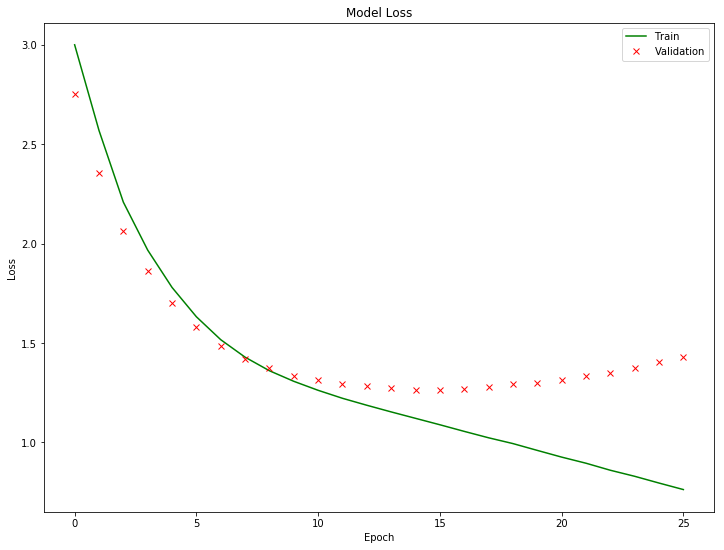

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,9))
plt.plot(history.history['loss'], 'g')
plt.plot(history.history['val_loss'], 'rx') #use if have val data
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.legend(['Train', 'Validation'], loc='upper right') #use if have val date
plt.show()

## Generate text

In [38]:
tf.train.latest_checkpoint(checkpoint_dir)

'./checkpoints_2019.05.11-11:28:57/ckpt_26'

In [39]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
#model.load_weights('./checkpoints_2019.04.29-00:31:15/ckpt_17')  #if the latest checkpoint is not your preferred
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))  #if the latest checkpoint is what you want
model.build(tf.TensorShape([1, None]))
model.summary()

W0511 11:44:34.060273 139886039209856 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f391251ec18>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0511 11:44:34.065123 139886039209856 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7f39124b9978>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            8704      
_________________________________________________________________
dropout_3 (Dropout)          (1, None, 256)            0         
_________________________________________________________________
unified_lstm_2 (UnifiedLSTM) (1, None, 1024)           5246976   
_________________________________________________________________
dropout_4 (Dropout)          (1, None, 1024)           0         
_________________________________________________________________
unified_lstm_3 (UnifiedLSTM) (1, None, 1024)           8392704   
_________________________________________________________________
dropout_5 (Dropout)          (1, None, 1024)           0         
_________________________________________________________________
dense_1 (Dense)              (1, None, 34)            

In [0]:
def generate_text(model, start_string):
    
    print('Generating with seed: "' + start_string + '"')
  
  # Number of characters to generate
    num_generate = 1000

  # Converting our start string to numbers (vectorizing)
    input_eval = [char2int[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    text_generated = []

    temperature = 1.0

  # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
      # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the word returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted word as the next input to the model
      # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(int2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [41]:
print(generate_text(model, start_string="joy of gods"))

Generating with seed: "joy of gods"
joy of gods! he said 
  then be what spear, by warriors to thy friend,
  with equal train distain'd the beether's ble,
  between his eyes and mortal mix impent!
   is this the god of jove. without thy throne,
  great partial deeps in end thine milds contern 
  amidst his conquering eyebellows,
  in yield tast the impending fate. were steed,
  and or may great, and great ulysses draws,
  and thick avenge his arted eyes beheld,
  light, horror, piercing through the gloomy shade. 
  steop'd with a rock, nor this celestial crowd,
  and shoot the swain and sees of their exking undended eloms with force.
  now, bring their hearts be bore a hero boree
  it rises, and his whole fame can save,
  or bore the kings of heaven, with shall detire,
  that moves and one has cause thee, and departs.
  the strokes approach my conquering troops putue.
  swift as the wind, within the steeds prepare.
  god of atrides, spare their heroes slain 
  let fierce defend the e c

In [0]:
with open('sampleTF2.txt', 'w') as f:
    sampleTF2 = generate_text(model, start_string="people rising")
    f.write(sampleTF2)

Generating with seed: "people rising"


Free memory resources if needed:

In [0]:
import signal

os.kill(os.getpid(), signal.SIGKILL)